# Notebook to check if seeded median and on-demand median identify the same spikes consistently

In [1]:
import fastplotlib as fpl 
import numpy as np
import zmq
import tifffile
import scipy
import random

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


In [2]:
file_path = "/home/clewis/repos/holo-nbs/rb26_20240111/raw_voltage_chunk.tif"
data = tifffile.memmap(file_path)
data.shape

(384, 3000001)

In [3]:
# define filter functions
def butter(cutoff, fs, order=5, btype='high'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a


def butter_filter(data, cutoff, fs, order=5, axis=-1, btype='high'):
    b, a = butter(cutoff, fs, order=order, btype=btype)
    y = scipy.signal.filtfilt(b, a, data, axis=axis)
    return y

In [4]:
median = np.median(butter_filter(data[:, :4000], 1_000, 30_000), axis=1)
median.shape

(384,)

In [22]:
ixs = random.choices(range(4_000, data.shape[1]), k=5)
ixs

[1751144, 2202227, 878603, 959199, 1277147]

In [23]:
ds = [butter_filter(data[:8, i:i+150], 1_000, 30_000) for i in ixs]

In [26]:
n = ["seeded median: ", "non-seeded median: "]*5

for i in range(len(ixs)):
    n[i * 2] += str(ixs[i])
    n[(i * 2) + 1] += str(ixs[i])

In [27]:
n

['seeded median: 1751144',
 'non-seeded median: 1751144',
 'seeded median: 2202227',
 'non-seeded median: 2202227',
 'seeded median: 878603',
 'non-seeded median: 878603',
 'seeded median: 959199',
 'non-seeded median: 959199',
 'seeded median: 1277147',
 'non-seeded median: 1277147']

RFBOutputContext()

JupyterRenderCanvas(css_height='1500.0px', css_width='800.0px')
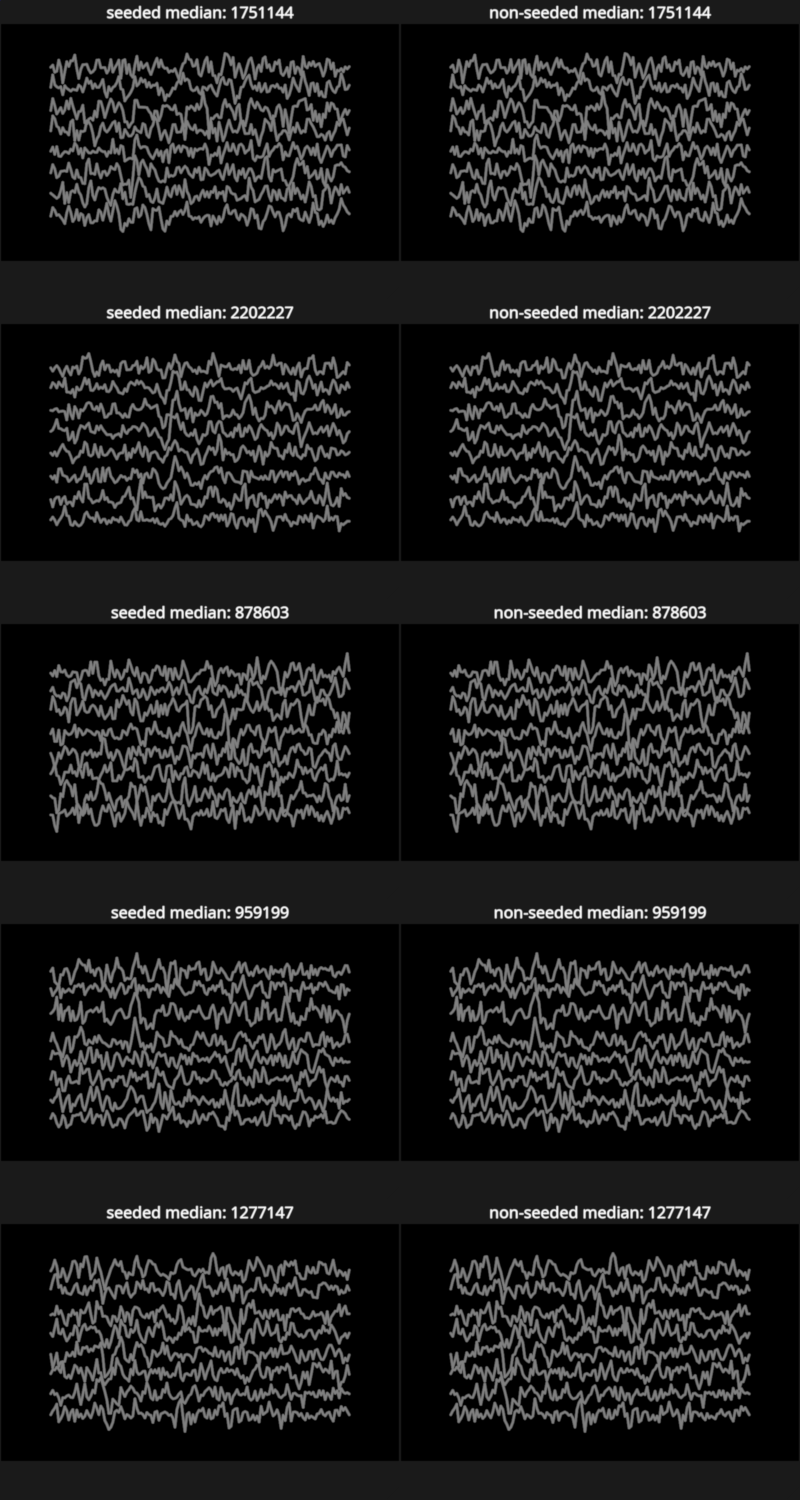

Draw error
Traceback (most recent call last):
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/rendercanvas/_coreutils.py", line 41, in log_exception
    yield
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/rendercanvas/base.py", line 456, in _draw_frame_and_present
    self._draw_frame()
  File "/home/clewis/repos/fastplotlib/fastplotlib/layouts/_imgui_figure.py", line 125, in _render
    self.imgui_renderer.render()
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/wgpu/utils/imgui/imgui_renderer.py", line 168, in render
    render_pass.end()
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/wgpu/backends/wgpu_native/_api.py", line 3509, in end
    libf.wgpuRenderPassEncoderEnd(self._internal)
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/wgpu/backends/wgpu_native/_helpers.py", line 457, in proxy_func
    raise wgpu_error
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/wgpu/backends/wgpu_native/_api.py"

In [28]:
fig = fpl.Figure(shape=(5,2), size=(800, 1500), names=n)

#fig[0,0].add_line_stack(butter_filter(data[:3, :4000], 1_000, 30_000), colors="gray")

for s in fig:
    s.axes.visible = False 

for i in range(5):
    fig[i, 0].add_line_stack(ds[i], colors="gray", name="lg")
    fig[i, 1].add_line_stack(ds[i], colors="gray", name="lg")

fig.show(maintain_aspect=False)

## Use the seeded median to calculate spikes

In [29]:
for j in range(5):
    lg = fig[j,0]["lg"]

    mad = scipy.stats.median_abs_deviation(ds[j], axis=1)

    thresh = (4 * mad) + median[:8]
    
    abs_data = np.abs(ds[j])
    
    # Find indices where threshold is crossed for each channel
    ixs = [np.where(abs_data[i] > thresh[i])[0] for i in range(ds[j].shape[0])]
    for i in range(len(ixs)):
        if ixs[i].shape[0] == 0:
            continue
        lg[i].colors[ixs[i]] = "orange"

## Use the median of the data to calculate spikes

In [30]:
for j in range(5):
    lg = fig[j,1]["lg"]

    mad = scipy.stats.median_abs_deviation(ds[j], axis=1)

    thresh = (4 * mad) + np.median(ds[j], axis=1)
    
    abs_data = np.abs(ds[j])
    
    # Find indices where threshold is crossed for each channel
    ixs = [np.where(abs_data[i] > thresh[i])[0] for i in range(ds[j].shape[0])]
    for i in range(len(ixs)):
        if ixs[i].shape[0] == 0:
            continue
        lg[i].colors[ixs[i]] = "orange"

# Save the image using `PIL`

In [33]:
arr = fig.export_numpy()

In [36]:
from PIL import Image
im = Image.fromarray(arr,  mode='RGBA')
im.save("/home/clewis/Desktop/your_file.png")